<a href="https://colab.research.google.com/github/GPN87/Image-detection/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/data/'


In [ ]:
os.listdir(data_dir)

['crimson', 'eastern']

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Start of loading data

In [ ]:
import numpy as np

In [ ]:
# keras utils is a data pipeline 'helper'. It builds the image dataset on the fly.
# batches them, classifies them. makes sure they are consistent size.
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 448 files belonging to 2 classes.


In [ ]:
#converts into a numpy iterator
#so we can actually access it
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

#each image in the batch consists of an array representing the image, and a '1' or '0' representing the classification

batch[0].shape
#It's really important to get the shape of your images, so you refer to them correctly in the model below.
#in this case, 32 images, with 256 height, 256 width, 3 channels (i.e. color)


(32, 256, 256, 3)

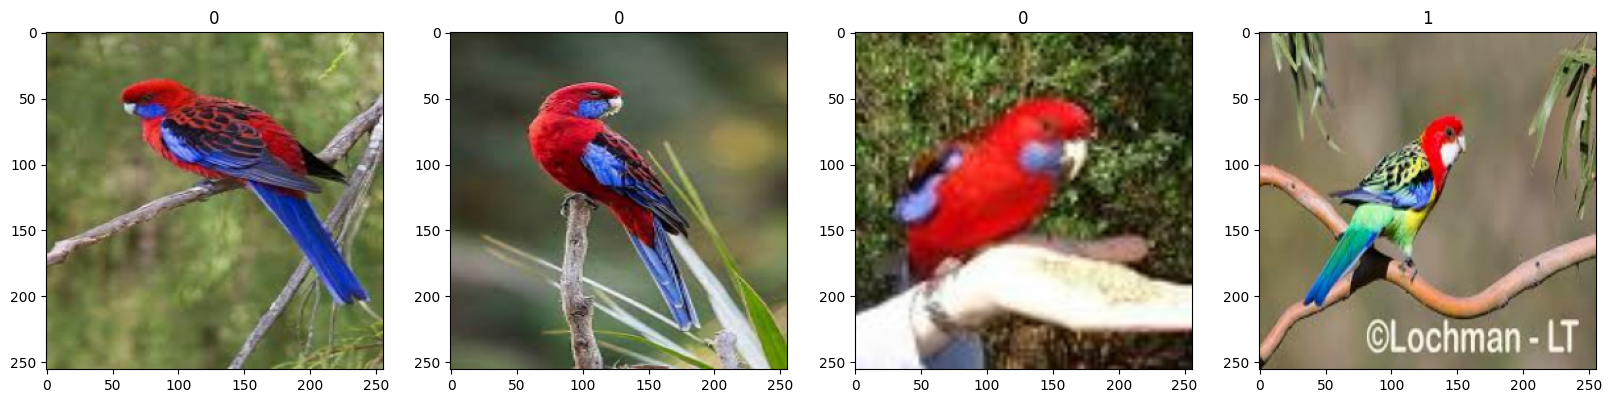

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#0s are crimsons and 1s are easterns

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         ...,
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607

Pre-processing the data

In [ ]:
#you've got to scale the image values to be between '0' and '1' instead of 0 to 255.
#you use a lambda function to do that
#The data pipeline has a 'map' function that allows us to lambda. So it makes the calculation automatically.
#'x' represents the image array. so we're dividing it by 255 to standardise the number. Nothing happens to 'y'
data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

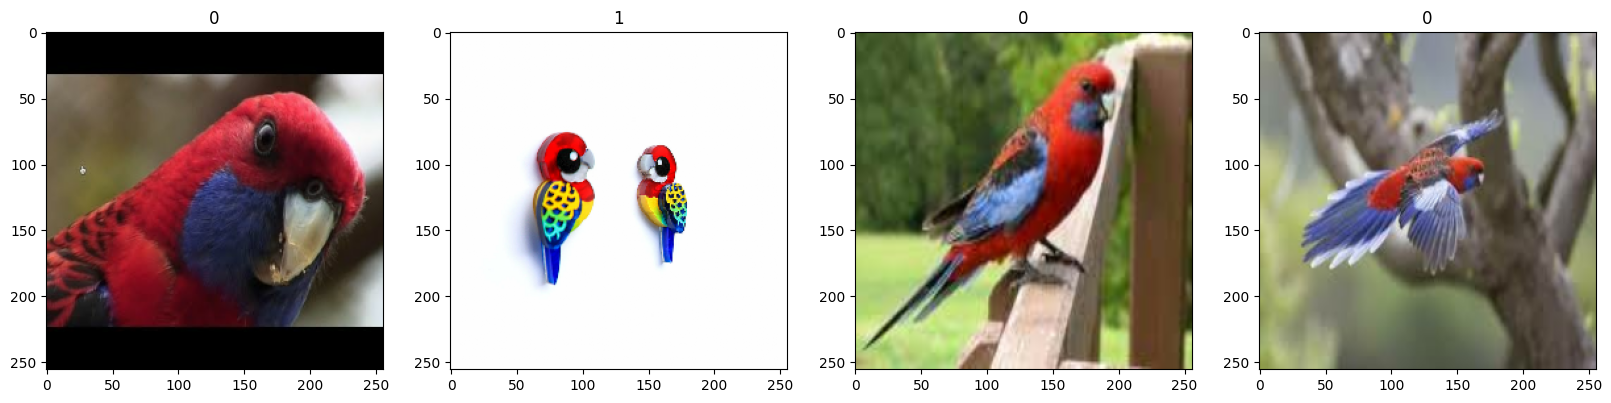

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data.

In [ ]:
len(data)

14

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train_size

9

In [ ]:
#Training data: what is used to train the model
#validation data: what we use to evaluate model while we're 
#Test data: used post training. 
# uses the 'Take' and 'skip' methods

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build Deep Learning Model

In [ ]:
#Uses the Keras sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#There are two model building APIs in tensorflow. The first is "sequential". Good when you've got one data input and one data output. Quick, easy.
#another is functional API. when you've got multiple connections.
#Conv2D, MaxPooling, Dense, Flatten, Dropout are all layers. See your background on CNN.

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#16 is the number of filters. Each filter matrix is 3x3 pixels. Each filter moves 1 pixel at a time. Input shape corresponds to the image array mentioned above.
#generally start with a relu activation function, if you dont want negative values. and output a sigmoid if '0' and '1'
#Dense layer = fully connected layer in Keras parlance.


In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#the metric we want to track is "accuracy"

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Train the data

In [ ]:
#create a log directory.
logdir = '/content/drive/MyDrive/logs/'

In [ ]:
#this creates a callback. Good for creating callbacks.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
9/9 [==============================] - 30s 3s/step - loss: 0.9238 - accuracy: 0.5139 - val_loss: 0.6901 - val_accuracy: 0.5521
Epoch 2/20
9/9 [==============================] - 31s 3s/step - loss: 0.6836 - accuracy: 0.6424 - val_loss: 0.6854 - val_accuracy: 0.5729
Epoch 3/20
9/9 [==============================] - 31s 3s/step - loss: 0.6820 - accuracy: 0.5868 - val_loss: 0.6703 - val_accuracy: 0.7604
Epoch 4/20
9/9 [==============================] - 31s 3s/step - loss: 0.6835 - accuracy: 0.6458 - val_loss: 0.6560 - val_accuracy: 0.6562
Epoch 5/20
9/9 [==============================] - 31s 3s/step - loss: 0.6493 - accuracy: 0.6632 - val_loss: 0.6188 - val_accuracy: 0.7500
Epoch 6/20
9/9 [==============================] - 28s 3s/step - loss: 0.5975 - accuracy: 0.7396 - val_loss: 0.5329 - val_accuracy: 0.8854
Epoch 7/20
9/9 [==============================] - 31s 3s/step - loss: 0.4631 - accuracy: 0.8056 - val_loss: 0.2836 - val_accuracy: 0.8958
Epoch 8/20
9/9 [==================

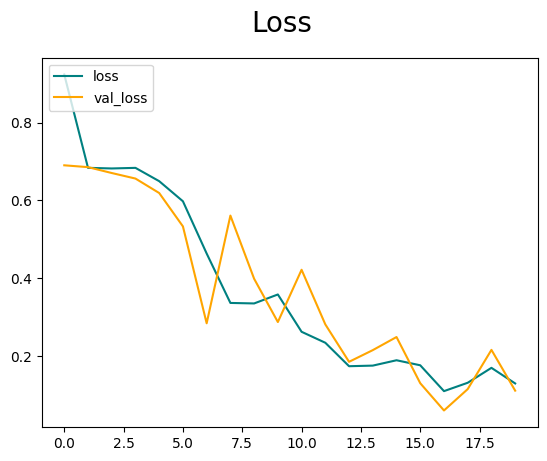

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

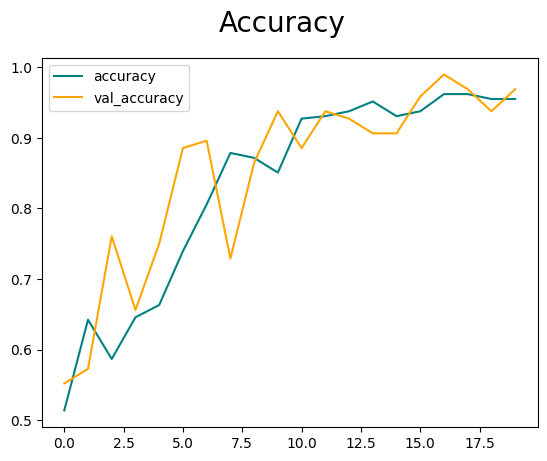

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 553ms/step


In [ ]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9090909361839294, Recall: 1.0, Accuracy: 0.96875


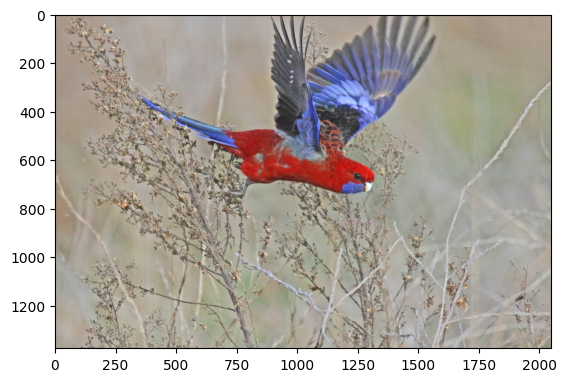

In [ ]:
filename = '/content/drive/MyDrive/crimsontest2.jpeg'
if os.path.exists(filename):
    img1 = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Error: Image file does not exist.")

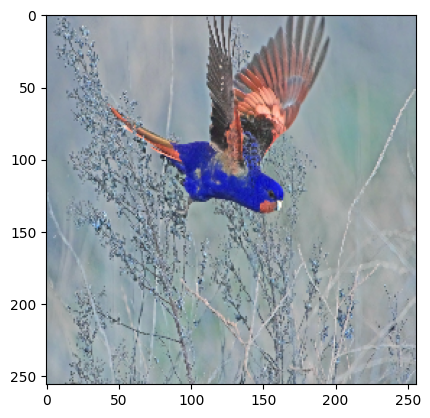

In [ ]:
resize = tf.image.resize(img1, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
#It's only a weird colour because we've opened it up in cv2.

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
#The Neural network expects a batch of images, not a single image.
#So we need to encapsulate it in another dimension.

1/1 [==============================] - 0s 43ms/step


In [ ]:
yhat

array([[0.36096868]], dtype=float32)

In [ ]:
if yhat > 0.5: 
    print(f'Beep boop.. this is an Eastern Rosella')
else:
    print(f'Beep boop.. this is a Crimson Rosella')

Beep boop.. this is a Crimson Rosella
